# Machine Learning Model #3
In this notebook, we are assessing the capabilities of machine learning to predict diabetes prevalence using only ACS data, simulating a scenario where we do not have access to the diabetes prevalence data from the CDC's BRFSS. We will use only ACS data to train our model and then evaluate its performance on the test set. The goal is to see if we can achieve a reasonable level of accuracy in predicting diabetes prevalence using only ACS data.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor

seed = 418
np.random.seed(seed)

In [5]:
df = pd.read_csv('../../02_data/02.02_processed/acs_brfss_21_22.csv')
df.drop(columns=['acs21_name'], inplace=True)

In [6]:
y1 = df[['fips']+[col for col in df.columns if '21' in col]]
y2 = df[['fips']+[col for col in df.columns if '22' in col]]

y1.columns = [col.replace('21', '') for col in y1.columns]
y2.columns = [col.replace('22', '') for col in y2.columns]

print("Y1 Dataframe:")
display(y1)
print("\nY2 Dataframe:")
display(y2)

Y1 Dataframe:


,fips,brfss_access2,brfss_checkup,brfss_csmoking,brfss_depression,brfss_diabetes,brfss_ghlth,brfss_mhlth,brfss_obesity,acs_pct_age_gte65,...,acs_pct_race_white,acs_pct_ses_pov,acs_pct_sex_female,acs_pct_sex_male,acs_pct_tp_veh_0,acs_pct_tp_veh_1,acs_pct_tp_veh_2,acs_pct_tp_veh_3,acs_pop_tot,brfss_totalpopulation
0,1001,10.4,76.0,16.9,22.7,10.7,17.3,18.0,38.9,15.1,...,75.1,13.6,51.6,48.4,5.4,31.5,33.8,29.3,58239,59095
1,1003,9.5,72.6,15.0,23.2,9.8,15.2,17.3,37.2,20.6,...,84.5,9.2,51.2,48.8,2.4,31.7,43.2,22.7,227131,239294
2,1005,17.2,76.6,25.0,22.6,15.6,27.3,20.5,43.4,19.0,...,45.5,26.5,47.1,52.9,11.2,33.3,33.8,21.7,25259,24964
3,1007,14.3,72.7,22.0,23.3,12.4,22.0,19.4,39.6,16.0,...,75.9,16.9,45.1,54.9,6.3,24.7,37.7,31.3,22412,22477
4,1009,13.1,72.7,19.6,24.2,10.5,18.6,18.8,37.7,18.0,...,92.5,13.2,49.9,50.1,4.5,25.0,32.1,38.4,58884,59041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,56037,15.0,69.9,17.8,20.2,8.8,14.4,16.1,34.3,12.7,...,86.8,10.5,48.5,51.5,2.1,21.6,37.8,38.5,42459,41614
3064,56039,10.4,66.1,11.1,17.4,6.6,10.0,12.7,21.7,15.5,...,85.2,7.1,47.3,52.7,2.7,30.0,43.1,24.3,23319,23575
3065,56041,13.5,63.5,16.8,20.1,8.3,14.1,15.7,33.3,14.7,...,92.1,8.0,49.1,50.9,3.6,24.0,30.3,42.1,20514,20635
3066,56043,14.0,62.7,16.4,19.5,8.4,13.7,15.3,33.6,22.3,...,85.7,6.6,48.5,51.5,3.9,25.0,38.4,32.7,7768,7705



Y2 Dataframe:


,fips,brfss_access2,brfss_checkup,brfss_csmoking,brfss_depression,brfss_diabetes,brfss_ghlth,brfss_mhlth,brfss_obesity,acs_pct_age_gte65,...,acs_pct_race_white,acs_pct_ses_pov,acs_pct_sex_female,acs_pct_sex_male,acs_pct_tp_veh_0,acs_pct_tp_veh_1,acs_pct_tp_veh_2,acs_pct_tp_veh_3,acs_pop_tot,brfss_totalpopulation
0,1001,9.0,77.9,15.4,24.3,11.3,17.7,18.0,38.4,15.6,...,74.4,11.4,51.2,48.8,4.0,31.7,34.7,29.6,58761,59759
1,1003,9.6,76.8,14.7,25.1,10.2,17.0,18.2,36.8,21.2,...,84.0,10.2,51.1,48.9,2.3,31.1,42.5,24.2,233420,246435
2,1005,16.6,79.1,21.9,23.5,16.0,28.4,21.1,43.8,19.8,...,45.5,24.2,47.9,52.1,11.7,33.3,32.0,22.9,24877,24706
3,1007,13.1,76.3,21.8,26.6,13.3,25.1,21.3,41.4,16.8,...,75.8,20.6,46.5,53.5,7.5,25.4,35.2,31.8,22251,22005
4,1009,16.1,75.2,19.5,28.0,11.6,22.6,21.1,37.3,18.3,...,91.3,14.2,49.4,50.6,4.8,24.9,32.7,37.6,59077,59512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,56037,12.3,66.6,17.9,22.2,9.4,15.9,17.3,36.3,13.6,...,84.8,11.7,48.2,51.8,2.0,23.7,37.2,37.1,42079,41345
3064,56039,11.3,68.3,11.3,19.4,7.1,10.6,13.5,22.2,16.6,...,83.2,6.9,48.1,51.9,1.9,31.1,41.8,25.2,23346,23287
3065,56041,12.6,66.8,18.2,24.2,9.0,16.1,18.1,35.5,15.6,...,91.3,6.5,49.2,50.8,3.7,25.5,31.1,39.6,20546,20712
3066,56043,13.4,65.3,18.5,22.4,9.4,17.1,18.1,39.1,23.3,...,86.0,6.7,47.6,52.4,4.7,25.0,36.1,34.2,7725,7719


In [7]:
dv_int = [
    'brfss_diabetes' # BRFSS Age-Adjusted Prevalence
]

dv_struct = [
    'acs_pct_dg_bb_int' #ACS Broadband Adoption
]

structural = [
    'acs_pct_age_gte65',
    'acs_pct_ed_9_12', 
    'acs_pct_ed_asc', 
    'acs_pct_ed_b',
    'acs_pct_ed_gr', 
    'acs_pct_ed_hs', 
    #'diff_acs_pct_ed_lt9', #reference
    'acs_pct_ed_sc', 
    'acs_pct_eth_hisp', 
    'acs_pct_occ_mgt',
    'acs_pct_occ_nat_res', 
    'acs_pct_occ_prod',
    'acs_pct_occ_sales', 
    'acs_pct_occ_svc',
    #'diff_acs_pct_occ_unemp', #reference
    'acs_pct_race_aian',
    'acs_pct_race_asian', 
    'acs_pct_race_black',
    'acs_pct_race_nhopi', 
    'acs_pct_race_other',
    'acs_pct_race_white', 
    'acs_pct_ses_pov',
    'acs_pct_sex_male',
    'acs_pop_tot'
]

intermediate = [
    'structural_internet_adoption',
    # 'brfss_access2', 
    # 'brfss_checkup',
    # 'brfss_csmoking', 
    # 'brfss_mhlth', 
    # 'brfss_obesity',
    #'diff_acs_pct_tp_veh_0', reference
    'acs_pct_tp_veh_1',
    'acs_pct_tp_veh_2', 
    'acs_pct_tp_veh_3'
]

index = [
    'fips'
]

                            OLS Regression Results                            
Dep. Variable:      acs_pct_dg_bb_int   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     236.9
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        11:22:42   Log-Likelihood:                -9112.4
No. Observations:                3068   AIC:                         1.827e+04
Df Residuals:                    3045   BIC:                         1.841e+04
Df Model:                          22                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  80.4634    

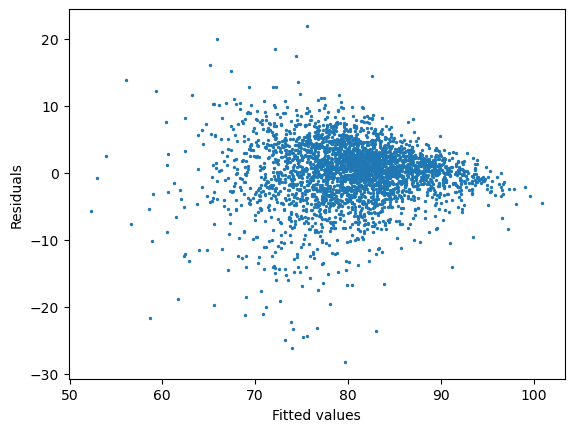

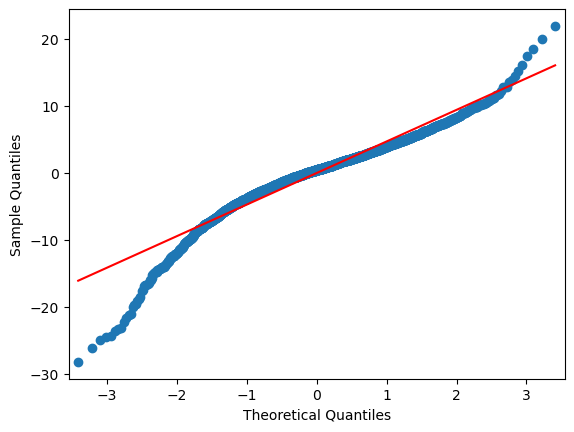

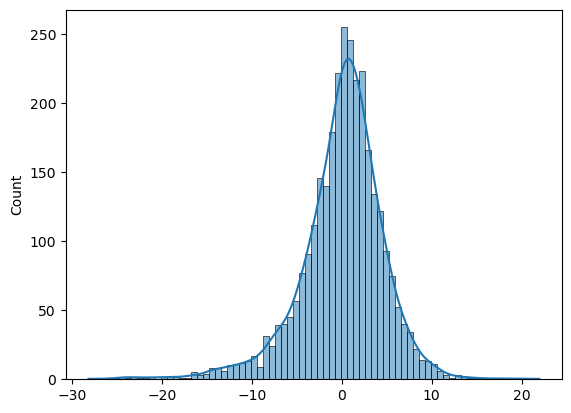

Mean Absolute Error: 3.3775546694476817
Root Mean Squared Error: 4.717103927251543


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,80.463,0.085,941.275,"80.296 , 80.631",80.296,80.631
1,acs_pct_age_gte65,-0.505,0.028,-18.038,"-0.56 , -0.45",-0.56,-0.45
2,acs_pct_ed_9_12,0.131,0.093,1.413,"-0.051 , 0.313",-0.051,0.313
3,acs_pct_ed_asc,0.435,0.073,5.959,"0.292 , 0.579",0.292,0.579
4,acs_pct_ed_b,0.410,0.066,6.200,"0.28 , 0.54",0.28,0.54
5,acs_pct_ed_gr,0.510,0.066,7.664,"0.379 , 0.64",0.379,0.64
6,acs_pct_ed_hs,0.203,0.061,3.332,"0.083 , 0.322",0.083,0.322
7,acs_pct_ed_sc,0.389,0.056,6.912,"0.279 , 0.499",0.279,0.499
8,acs_pct_eth_hisp,-0.034,0.020,-1.742,"-0.073 , 0.004",-0.073,0.004
9,acs_pct_occ_mgt,1.027,1.315,0.781,"-1.55 , 3.605",-1.55,3.605


                            OLS Regression Results                            
Dep. Variable:      acs_pct_dg_bb_int   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     214.7
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        11:22:42   Log-Likelihood:                -8966.0
No. Observations:                3068   AIC:                         1.798e+04
Df Residuals:                    3045   BIC:                         1.812e+04
Df Model:                          22                                         
Covariance Type:                  HC1                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  82.3647    

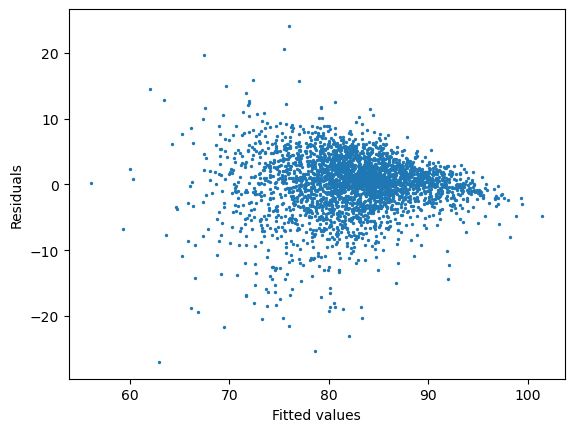

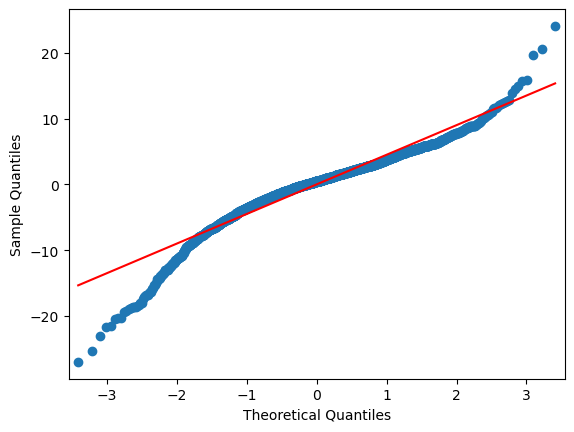

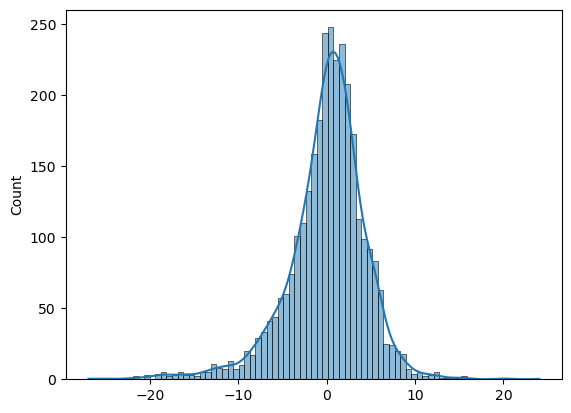

Mean Absolute Error: 3.2110528878771443
Root Mean Squared Error: 4.497374681609584


,Variable,Coef,Std Err,t,95% CI,CI Lower,CI Upper
0,const,82.365,0.082,1010.592,"82.205 , 82.524",82.205,82.524
1,acs_pct_age_gte65,-0.414,0.025,-16.342,"-0.464 , -0.365",-0.464,-0.365
2,acs_pct_ed_9_12,0.205,0.102,2.020,"0.006 , 0.405",0.006,0.405
3,acs_pct_ed_asc,0.409,0.076,5.404,"0.261 , 0.557",0.261,0.557
4,acs_pct_ed_b,0.411,0.070,5.894,"0.274 , 0.547",0.274,0.547
5,acs_pct_ed_gr,0.487,0.075,6.490,"0.34 , 0.634",0.34,0.634
6,acs_pct_ed_hs,0.201,0.069,2.925,"0.066 , 0.335",0.066,0.335
7,acs_pct_ed_sc,0.358,0.065,5.538,"0.232 , 0.485",0.232,0.485
8,acs_pct_eth_hisp,-0.081,0.073,-1.118,"-0.224 , 0.061",-0.224,0.061
9,acs_pct_occ_mgt,0.268,1.263,0.212,"-2.207 , 2.743",-2.207,2.743


In [8]:
analysis_list = [ y1, y2]
for df in analysis_list:
    X_struct = df[structural]
    X_struct = X_struct - X_struct.mean()
    X_struct = sm.add_constant(X_struct)

    y = df[dv_struct]
    #OLS with HC1 robust standard errors
    model = sm.OLS(y, X_struct).fit(cov_type='HC1')

    df['structural_internet_adoption'] = model.predict(X_struct)

    #model summary
    print(model.summary())

    #plto residuals
    fig, ax = plt.subplots()
    ax.scatter(model.fittedvalues, model.resid, s=2) 
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    plt.show()

    #QQ plot
    fig, ax = plt.subplots()
    sm.qqplot(model.resid, line='s', ax=ax)
    plt.show()

    #distribution of residuals
    sns.histplot(model.resid, kde=True)
    plt.show()


    mae = np.mean(np.abs(model.resid))
    print(f'Mean Absolute Error: {mae}')
    rmse = np.sqrt(np.mean(model.resid**2))
    print(f'Root Mean Squared Error: {rmse}')

    #dataframe with variable names, coefficients, std err, standardised coefficients, t-values, 95% CI
    results = pd.DataFrame(model.params, columns=['Coef'])
    results['Std Err'] = model.bse
    results['t'] = model.tvalues
    results['95% CI'] = model.conf_int()[0]
    #display CI as two string values in the column rounded to 4 decimal places
    results['95% CI'] = results['95% CI'].round(3).astype(str) + ' , ' + model.conf_int()[1].round(3).astype(str)
    #seperate the CI into two columns
    results[['CI Lower', 'CI Upper']] = results['95% CI'].str.split(',', expand=True)
    results = results.reset_index()
    results = results.rename(columns={'index':'Variable'})
    results = results.round(3)
    display(results)    

In [9]:
# y1 is train, y2 is test x = intermediate, y = dv_int
X_train = y1[index + intermediate]
X_test = y2[index + intermediate]
y_train = y1[dv_int]
y_train = y_train.values.ravel()
y_test = y2[dv_int]
y_test = y_test.values.ravel()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Random Forest': RandomForestRegressor(random_state=seed),
        'Gradient Boosting': GradientBoostingRegressor(random_state=seed),
        'XGBoost': XGBRegressor(random_state=seed)
    }
    
    results = {}
    
    for name, model in models.items():
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        results[name] = {
            'R2': r2_score(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': root_mean_squared_error(y_test, y_pred),
            'CV_Score': np.mean(cross_val_score(model, X_train, y_train, cv=5))
        }
    
    return results

# Run model evaluation
model_results = evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

In [11]:
model_results

{'Linear Regression': {'R2': 0.3419293722134751,
  'MSE': 3.5412142241925206,
  'MAE': 1.4895200741640333,
  'RMSE': 1.881811420996408,
  'CV_Score': np.float64(0.6096839270178493)},
 'Ridge': {'R2': 0.341976471185215,
  'MSE': 3.5409607748792893,
  'MAE': 1.489454943009701,
  'RMSE': 1.8817440779445247,
  'CV_Score': np.float64(0.6097045159752303)},
 'Lasso': {'R2': 0.19294394637312917,
  'MSE': 4.342935630537313,
  'MAE': 1.594480990049733,
  'RMSE': 2.083971120370269,
  'CV_Score': np.float64(0.3501834959360488)},
 'Random Forest': {'R2': 0.5287304953833276,
  'MSE': 2.535998725228161,
  'MAE': 1.242348435462842,
  'RMSE': 1.5924819387447258,
  'CV_Score': np.float64(0.6135158299220205)},
 'Gradient Boosting': {'R2': 0.5347389997447135,
  'MSE': 2.5036657199058743,
  'MAE': 1.2467743353882113,
  'RMSE': 1.582297607880981,
  'CV_Score': np.float64(0.6051363693040184)},
 'XGBoost': {'R2': 0.5927781530475904,
  'MSE': 2.1913450258072,
  'MAE': 1.1603672980640516,
  'RMSE': 1.4803192310

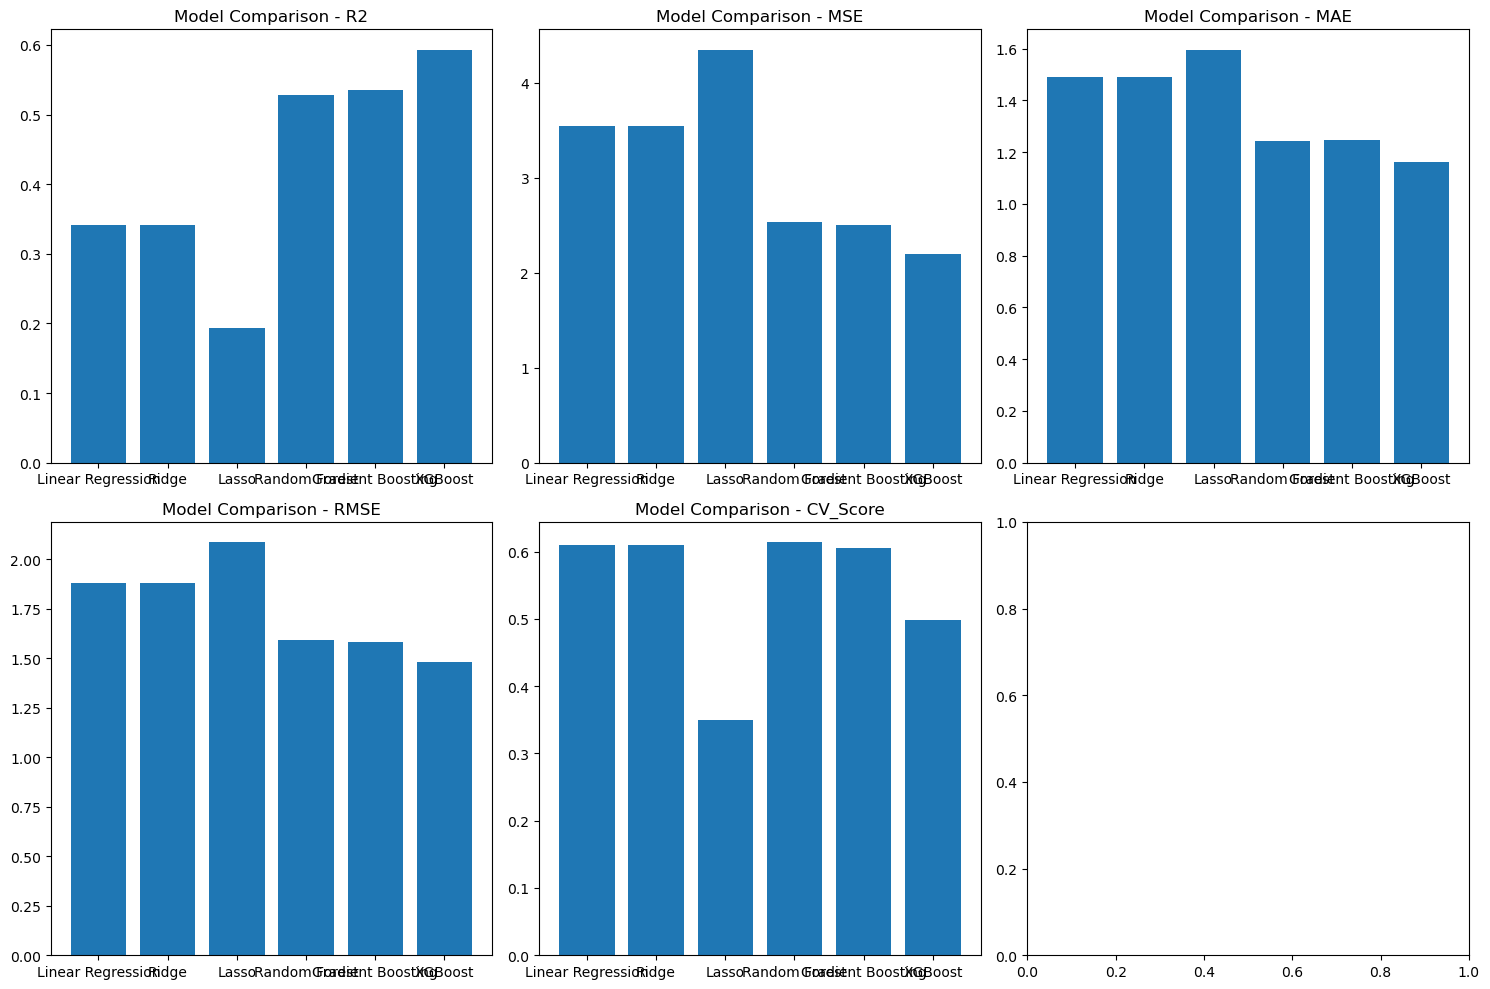

In [12]:
def plot_model_comparison(results):
    metrics = ['R2', 'MSE', 'MAE', 'RMSE', 'CV_Score']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        values = [results[model][metric] for model in results.keys()]
        ax = axes[idx]
        ax.bar(results.keys(), values)
        ax.set_title(f'Model Comparison - {metric}')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison(model_results)

In [13]:
def perform_grid_search():
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    }
    
    xgb = XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                             cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    grid_search.fit(X_train_scaled, y_train)
    
    return grid_search

# Perform grid search
grid_search_results = perform_grid_search()

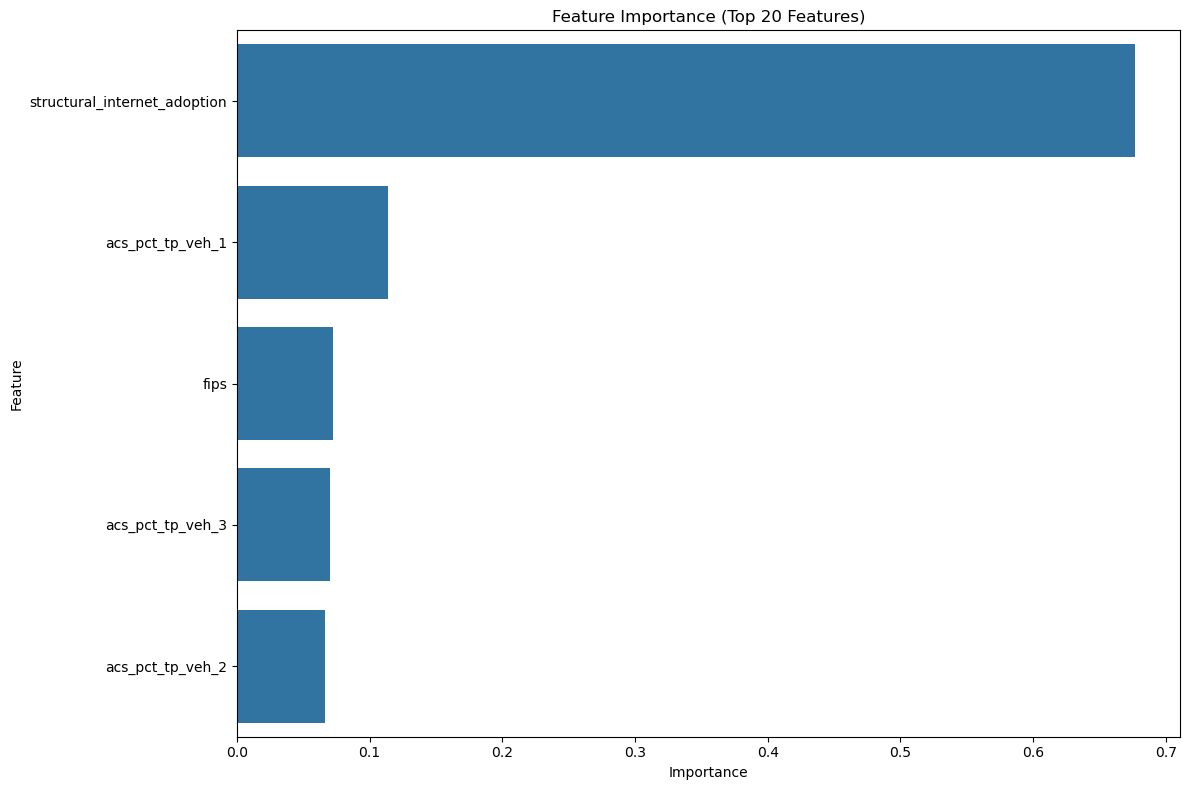

Top 10 most important features:
                        Feature  Importance
1  structural_internet_adoption    0.676866
2              acs_pct_tp_veh_1    0.113823
0                          fips    0.072551
4              acs_pct_tp_veh_3    0.070215
3              acs_pct_tp_veh_2    0.066545


In [14]:
def analyze_feature_importance():
    # Train best model from grid search
    best_model = grid_search_results.best_estimator_
    best_model.fit(X_train_scaled, y_train)
    
    # Get feature importance from the model
    importances = best_model.feature_importances_
    
    # Create a DataFrame to sort and visualize feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
    plt.title('Feature Importance (Top 20 Features)')
    plt.tight_layout()
    plt.show()
    
    # Print top 10 features
    print("Top 10 most important features:")
    print(feature_importance_df.head(10))
    
    return best_model

best_model = analyze_feature_importance()

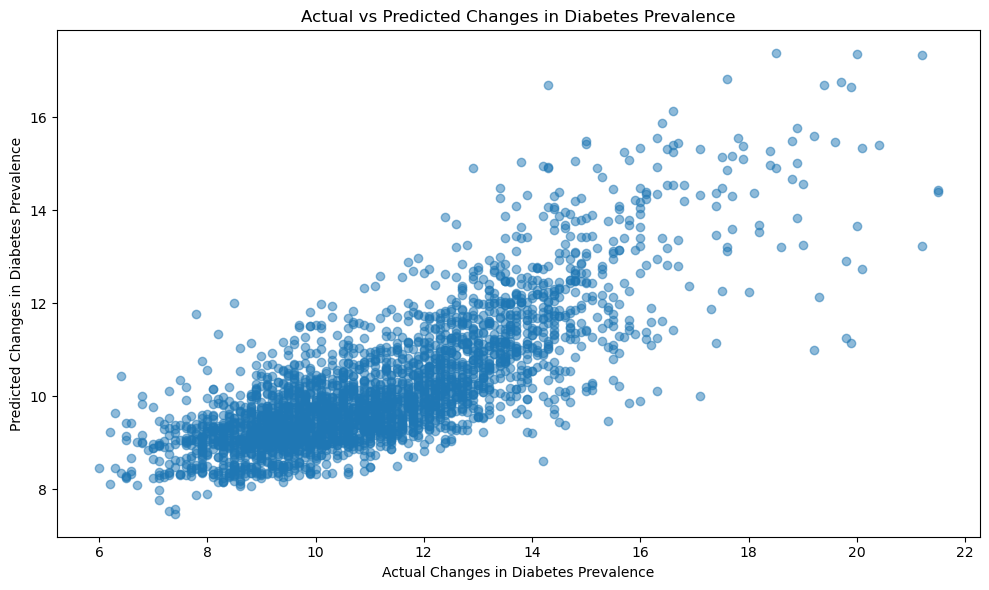

Final Model Evaluation Metrics:
R2: 0.4039
MSE: 3.2077
MAE: 1.4013
RMSE: 1.7910


In [15]:
def evaluate_final_model(model, X_test_scaled, y_test):
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    final_metrics = {
        'R2': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred)
    }
    
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual Changes in Diabetes Prevalence')
    plt.ylabel('Predicted Changes in Diabetes Prevalence')
    plt.title('Actual vs Predicted Changes in Diabetes Prevalence')
    plt.tight_layout()
    plt.show()
    
    return final_metrics

final_metrics = evaluate_final_model(best_model, X_test_scaled, y_test)
#print final metrics
print("Final Model Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")